# Basic Plots, Groupping and Multi-Level Tables

Inspiration and some of the parts came from: Python Data Science [GitHub repository](https://github.com/jakevdp/PythonDataScienceHandbook/tree/master), [MIT License](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/LICENSE-CODE) and [Introduction to Pandas](https://colab.research.google.com/notebooks/mlcc/intro_to_pandas.ipynb) by Google, [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0)

If running this from Google Colab, uncomment the cell below and run it. Otherwise, just skip it.

In [1]:
#!pip install seaborn
#!pip install watermark
#!pip install pivottablejs

In [2]:
import pandas as pd
import seaborn as sns

# For generating a pivot table widget
from pivottablejs import pivot_ui
from IPython.display import HTML
from IPython.display import IFrame
import json, io

## Learning Objectives:


 * Simple plotting from *DataFrame*

 * split-apply-combine on tidy data

 * Pivot tables

 For this notebook, we will use the california housing dataframes.

In [3]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


## Simple Plotting

The example below is using `DataFrame.describe` to show interesting statistics about a `DataFrame`.

In [4]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Another powerful feature of *pandas* is graphing. For example, `DataFrame.hist` lets you quickly study the distribution of values in a column:

array([[<Axes: title={'center': 'housing_median_age'}>]], dtype=object)

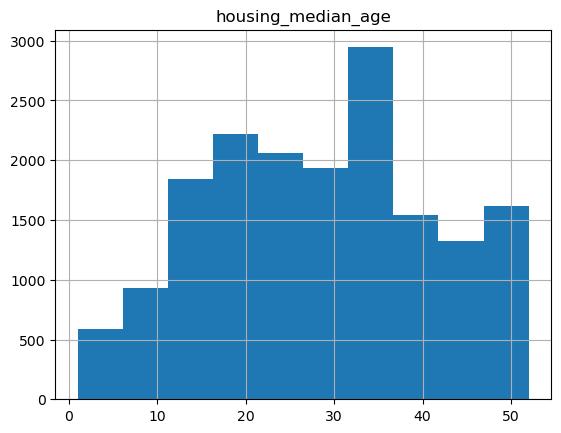

In [5]:
california_housing_dataframe.hist('housing_median_age')

Another example, `DataFrame.plot.scatter` lets you quickly study the possition of houses:

<Axes: xlabel='longitude', ylabel='latitude'>

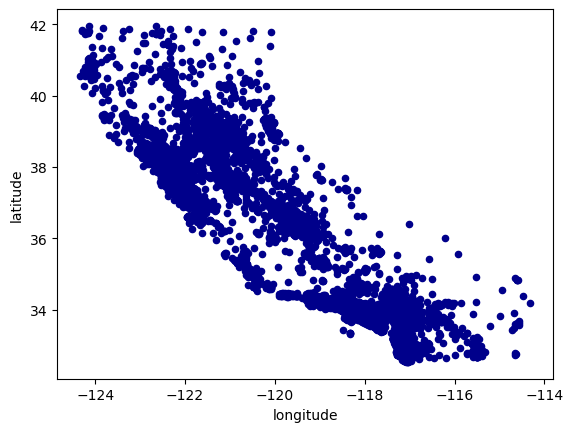

In [6]:
california_housing_dataframe.plot.scatter(x='longitude',
                      y='latitude',
                      c='DarkBlue')

Boxplots can also be displayed with `DataFrame.boxplot`.

<Axes: >

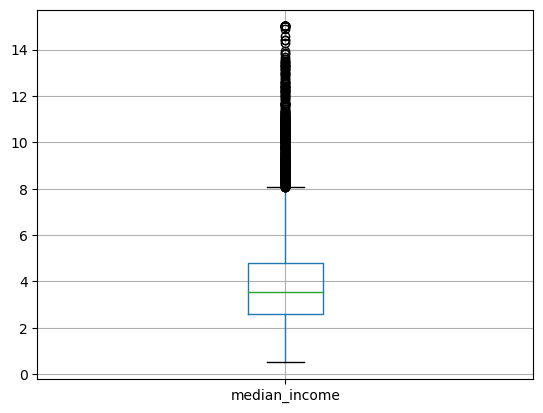

In [7]:
california_housing_dataframe.boxplot(column=["median_income"])

You can learn other plot options in the plot section of the pandas API [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html).

## Split-apply-combine on Tidy Data

### Tidy Data

Hadley Wickham wrote a great [article](https://www.jstatsoft.org/article/view/v059i10) in favor of “tidy data.” Tidy data frames follow the rules:

* Each variable is a column.

* Each observation is a row.

* Each type of observation has its own separate data frame.

This is less pretty to visualize as a table (you may notice too many rows with repeated values in certain columns), but the representation of data which is convenient for visualization is different from that which is convenient for analysis. A tidy data frame is almost always much easier to work with than non-tidy formats.

Let's look at the titanic dataset below.

In [8]:
# load dataset titanic from seaborn package
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


According to the statements above, this dataframe is tidy, so it is easier to process.

### Split-apply-combine

We might be interested in computing a statistic, let's say the survival mean, not for the entire data, but according to subgroups.
Basically, we want to:

* Split the data according to the 'sex' criterion field, i.e., split it up so we have a separate data set for the two classes, you for 'male' and one for 'female'.

* Apply a function (`mean`) to the 'survived' field in these split data sets.

* Combine the results of these averages on the split data set into a new, summary data set that contains the two classes ('male' and 'female') and mean survival rate for each.

The first step is to apply a `groupby` operation.

In [9]:
grouped = titanic.groupby('sex')
grouped

There is not much to see in the DataFrameGroupBy object that resulted. But there is a lot we can do with this object.
Now, we apply the `mean` function and check the combined result of this operation.

In [10]:
mean_measurements_per_sex = grouped.mean(numeric_only = True)
mean_measurements_per_sex

,survived,pclass,age,sibsp,parch,fare,adult_male,alone
sex,,,,,,,,
female,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818,0.000000,0.401274
male,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893,0.930676,0.712305


Here the `numeric_only` option is set to disconsider for calculating mean over columns that contain strings like 'embark_town' for example.

The 'sex' field is now the index of our dataframe. We can put it back as a column with the `.reset_index` method.

In [11]:
mean_measurements_per_sex = mean_measurements_per_sex.reset_index()
mean_measurements_per_sex

,sex,survived,pclass,age,sibsp,parch,fare,adult_male,alone
0,female,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818,0.000000,0.401274
1,male,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893,0.930676,0.712305


We may choose to display only the 'sex' and 'survived' columns.

In [12]:
mean_measurements_per_sex[['sex', 'survived']]

,sex,survived
0,female,0.742038
1,male,0.188908


Now that you know all the individual steps, here is all the above steps in one shot.

In [13]:
mean_survival_per_sex = titanic.groupby('sex').mean(numeric_only = True).reset_index()[['sex', 'survived']]
mean_survival_per_sex

,sex,survived
0,female,0.742038
1,male,0.188908


## Pivot Tables

This is useful, but we might like to go one step deeper and look at survival rates by both sex and, say, class.
Using the vocabulary of `groupby`, we might proceed using a process like this:
we first *group by* 'class' **and** 'sex', then *select* survival, *apply* a mean aggregate, *combine* the resulting groups, and finally *unstack* the hierarchical index to reveal the hidden multidimensionality. In code:

In [14]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This gives us a better idea of how both sex and class affected survival, but the code is starting to look a bit garbled.
While each step of this pipeline makes sense in light of the tools we've previously discussed, the long string of code is not particularly easy to read or use.
This two-dimensional `groupby` is common enough that Pandas includes a convenience routine, `pivot_table`, which succinctly handles this type of multidimensional aggregation.

### Pivot Table Syntax

Here is the equivalent to the preceding operation using the `DataFrame.pivot_table` method:

In [15]:
titanic.pivot_table('survived', index='sex', columns='class', aggfunc='mean')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This is eminently more readable than the manual `groupby` approach, and produces the same result.
As you might expect of an early 20th-century transatlantic cruise, the survival gradient favors both higher classes and people recorded as females in the
data. First-class females survived with near certainty (hi, Rose!), while only one in eight or so third-class males survived (sorry, Jack!).

## Pivot Table Widgets

Some of the widgets needs to be specificaly tweaked for Google Colab or Jupyter Notebooks

In [16]:
from pivottablejs import pivot_ui
from IPython.display import HTML
from IPython.display import IFrame
import json, io

# Google colab alternative template

TEMPLATE = u"""
<!DOCTYPE html>
<html>
    <head>
        <meta charset="UTF-8">
        <title>PivotTable.js</title>

        <!-- external libs from cdnjs -->
        <link rel="stylesheet" type="text/css" href="https://cdnjs.cloudflare.com/ajax/libs/c3/0.4.11/c3.min.css">
        <script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.5/d3.min.js"></script>
        <script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/c3/0.4.11/c3.min.js"></script>
        <script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/jquery/1.11.2/jquery.min.js"></script>
        <script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/jqueryui/1.11.4/jquery-ui.min.js"></script>
        <script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/jquery-csv/0.71/jquery.csv-0.71.min.js"></script>


        <link rel="stylesheet" type="text/css" href="https://cdnjs.cloudflare.com/ajax/libs/pivottable/2.19.0/pivot.min.css">
        <script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/pivottable/2.19.0/pivot.min.js"></script>
        <script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/pivottable/2.19.0/d3_renderers.min.js"></script>
        <script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/pivottable/2.19.0/c3_renderers.min.js"></script>
        <script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/pivottable/2.19.0/export_renderers.min.js"></script>

        <style>
            body {font-family: Verdana;}
            .node {
              border: solid 1px white;
              font: 10px sans-serif;
              line-height: 12px;
              overflow: hidden;
              position: absolute;
              text-indent: 2px;
            }
            .c3-line, .c3-focused {stroke-width: 3px !important;}
            .c3-bar {stroke: white !important; stroke-width: 1;}
            .c3 text { font-size: 12px; color: grey;}
            .tick line {stroke: white;}
            .c3-axis path {stroke: grey;}
            .c3-circle { opacity: 1 !important; }
            .c3-xgrid-focus {visibility: hidden !important;}
        </style>
    </head>
    <body>
        <script type="text/javascript">
            $(function(){

                $("#output").pivotUI(
                    $.csv.toArrays($("#output").text())
                    , $.extend({
                        renderers: $.extend(
                            $.pivotUtilities.renderers,
                            $.pivotUtilities.c3_renderers,
                            $.pivotUtilities.d3_renderers,
                            $.pivotUtilities.export_renderers
                            ),
                        hiddenAttributes: [""]
                    }
                    , {
                        onRefresh: function(config) {
                            var config_copy = JSON.parse(JSON.stringify(config));
                            //delete some values which are functions
                            delete config_copy["aggregators"];
                            delete config_copy["renderers"];
                            //delete some bulky default values
                            delete config_copy["rendererOptions"];
                            delete config_copy["localeStrings"];
                            $("#output2").text(JSON.stringify(config_copy, undefined, 2));
                        }
                    }
                    , %(kwargs)s
                    , %(json_kwargs)s)
                ).show();
             });
        </script>
        <div id="output" style="display: none;">%(csv)s</div>

        <textarea id="output2"
        style="float: left; width: 0px; height: 0px; margin: 0px; opacity:0;" readonly>
        </textarea>

        <button onclick="copyTextFunction()">Copy settings</button>
        <script>
        function copyTextFunction() {
                    var copyText = document.getElementById("output2");
                    copyText.select();
                    document.execCommand("copy");
                    }
        </script>

    </body>
</html>
"""


def pivot_cht_html(df, outfile_path = "pivottablejs.html", url="",
    width="100%", height="500",json_kwargs='',  **kwargs):
  with io.open(outfile_path, 'wt', encoding='utf8') as outfile:
      csv = df.to_csv(encoding='utf8')
      if hasattr(csv, 'decode'):
          csv = csv.decode('utf8')
      outfile.write(TEMPLATE %
            dict(csv=csv, kwargs=json.dumps(kwargs),json_kwargs=json_kwargs))

  IFrame(src=url or outfile_path, width=width, height=height)
  return HTML(outfile_path)

Calling the function 'pivot_ui' with Pandas DataFrame as input will allow you interactively explore and plot its values

In [17]:
pivot_ui(titanic)
HTML('pivottablejs.html')

**Watermark**

In [18]:
from watermark import watermark
watermark(iversions=True, globals_=globals())
print(watermark())
print(watermark(packages="watermark,numpy,pandas,seaborn,pivottablejs"))

Last updated: 2023-08-25T10:51:16.460182+02:00

Python implementation: CPython
Python version       : 3.9.17
IPython version      : 8.14.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 16
Architecture: 64bit

watermark   : 2.4.3
numpy       : 1.23.5
pandas      : 2.0.3
seaborn     : 0.12.2
pivottablejs: 0.9.0

